In [37]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)



<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

## 2D cases

In [38]:

# File name
data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_fully/results/"

# GB information
step_num=121
grain_nums = 20001
time_interval = 30
curvature_limit = 0.0182
area_limit = 100
# case_name_list = ["MI_20k_fully", "M_20k_fully", "I_20k_fully", "MI_20k", "M_20k", "I_20k"]
# case_name_list = ["MI_20k_fully"]
case_name_list = ["M_20k"]

GB_sides_num = np.zeros((len(case_name_list),step_num,grain_nums))
for case_i in range(len(case_name_list)):
    case_name = case_name_list[case_i]
    
    GB_infomation_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/2D_signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        if not os.path.exists(data_file_folder + data_file_name): 
            print("Please calculate GB information first")
            break
        
        npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
        GB_infomation_dict = npz_file["GB_infomation_dict"].item()
        GB_infomation_dict_list.append(GB_infomation_dict)
        
        for key in GB_infomation_dict:
            grain_pair_i, grain_pair_j = (GB_infomation_dict[key][6:8]).astype(int)
            GB_sides_num[case_i,time_step,grain_pair_i] += 1
            GB_sides_num[case_i,time_step,grain_pair_j] += 1
        



100%|██████████| 121/121 [00:03<00:00, 31.02it/s]


In [39]:

for case_i in range(len(case_name_list)):
    case_name = case_name_list[case_i]
    
    # store all GB points, include curvature and anti-curvature(include randomness points)
    GB_list_velocity_list = []
    GB_list_curvature_list = []
    GB_list_GBenergy_list = []
    GB_list_area_list = []
    GB_list_dV_direction1 = []
    GB_list_dV_direction2 = []
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()
    GB_id_focus_detail = dict()
    GB_filter_kernel = [set(),set(),set(),set(),set()]
    dV_dict = []
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_area_list_tmp = []
        GB_list_dV_direction1_tmp = []
        GB_list_dV_direction2_tmp = []
        key_set = set()

        # MP
        # remove disappeared GBs and low area GBs and remove low curvature
        print(f"key num start with {len(GB_infomation_dict_list[time_step])}")
        tmp_GB_infomation_dict_for_mp = {}
        for key in GB_infomation_dict_list[time_step]:
            if (GB_infomation_dict_list[time_step][key][5] < area_limit or 
                GB_infomation_dict_list[time_step+1].get(key) is None or 
                abs(GB_infomation_dict_list[time_step][key][4]) < curvature_limit): 
                continue
            tmp_GB_infomation_dict_for_mp[key] = GB_infomation_dict_list[time_step][key]
        print(f"key num end with {len(tmp_GB_infomation_dict_for_mp)}")
        # run key
        dV_dict_file_name = f"GB_velocity_data/2D_dV_split_data_{case_name}_areaLimit{area_limit}_step{time_step}.npz"
        npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
        dV_dict_tmp = npz_file["dV_dict_tmp"]
        dV_dict_tmp=dV_dict_tmp.item()

        for key in tqdm(tmp_GB_infomation_dict_for_mp):
            result = dV_dict_tmp[key]
            
            # Store these results remove ways-area,lowCurvature
            GB_list_velocity_list_tmp.append(result["velocity"])
            GB_list_curvature_list_tmp.append(result["current_curvature_value"])
            GB_list_GBenergy_list_tmp.append(result["current_eng"])
            GB_list_dV_direction1_tmp.append(result["dV_direction1"])
            GB_list_dV_direction2_tmp.append(result["dV_direction2"])
            # calculate GB area and store it
            GB_list_area_list_tmp.append(0.5*tmp_GB_infomation_dict_for_mp[key][0])


            # keep anti-curvature GB info
            if result["is_anti_curvature"]: 
                key_set.add(key)
                if time_step >= step_num-3: continue
                if key in GB_id_focus: 
                    GB_id_focus[key] += 1
                    GB_id_focus_detail[key].append(time_step)
                else: 
                    GB_id_focus[key] = 1
                    GB_id_focus_detail[key] = [time_step]

        # keep all GBs after ways-area,lowCurvature
        dV_dict.append(dV_dict_tmp)
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        GB_list_area_list.append(GB_list_area_list_tmp)
        GB_list_dV_direction1.append(GB_list_dV_direction1_tmp)
        GB_list_dV_direction2.append(GB_list_dV_direction2_tmp)

        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        # # filter the anti-curvature GB with 00100
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[3]|GB_filter_kernel[4])
        
        for key in filtered_set: 
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step-2)
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")


    # filter the GBs in GB_id_focus without anti-curvature behavior after 00100
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <=0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)

key num start with 22827
key num end with 0


0it [00:00, ?it/s]


finish 0 with num of GBs 0, and collected num of GBs 0
key num start with 17551
key num end with 151


100%|██████████| 151/151 [00:00<00:00, 315251.32it/s]


finish 1 with num of GBs 151, and collected num of GBs 63
key num start with 14667
key num end with 313


100%|██████████| 313/313 [00:00<00:00, 521580.12it/s]


finish 2 with num of GBs 313, and collected num of GBs 168
key num start with 12185
key num end with 363


100%|██████████| 363/363 [00:00<00:00, 498047.87it/s]


finish 3 with num of GBs 363, and collected num of GBs 265
key num start with 10450
key num end with 389


100%|██████████| 389/389 [00:00<00:00, 435437.48it/s]


finish 4 with num of GBs 389, and collected num of GBs 349
key num start with 9076
key num end with 336


100%|██████████| 336/336 [00:00<00:00, 483460.08it/s]


finish 5 with num of GBs 336, and collected num of GBs 408
key num start with 7963
key num end with 323


100%|██████████| 323/323 [00:00<00:00, 56898.79it/s]


finish 6 with num of GBs 323, and collected num of GBs 465
key num start with 7133
key num end with 275


100%|██████████| 275/275 [00:00<00:00, 390597.22it/s]


finish 7 with num of GBs 275, and collected num of GBs 504
key num start with 6490
key num end with 277


100%|██████████| 277/277 [00:00<00:00, 409958.44it/s]


finish 8 with num of GBs 277, and collected num of GBs 539
key num start with 5905
key num end with 263


100%|██████████| 263/263 [00:00<00:00, 397371.02it/s]


finish 9 with num of GBs 263, and collected num of GBs 577
key num start with 5468
key num end with 241


100%|██████████| 241/241 [00:00<00:00, 363214.97it/s]


finish 10 with num of GBs 241, and collected num of GBs 603
key num start with 5097
key num end with 233


100%|██████████| 233/233 [00:00<00:00, 464704.15it/s]


finish 11 with num of GBs 233, and collected num of GBs 624
key num start with 4704
key num end with 236


100%|██████████| 236/236 [00:00<00:00, 384410.00it/s]


finish 12 with num of GBs 236, and collected num of GBs 647
key num start with 4397
key num end with 208


100%|██████████| 208/208 [00:00<00:00, 543560.89it/s]


finish 13 with num of GBs 208, and collected num of GBs 658
key num start with 4161
key num end with 211


100%|██████████| 211/211 [00:00<00:00, 378042.78it/s]


finish 14 with num of GBs 211, and collected num of GBs 676
key num start with 3922
key num end with 199


100%|██████████| 199/199 [00:00<00:00, 408349.56it/s]


finish 15 with num of GBs 199, and collected num of GBs 692
key num start with 3748
key num end with 179


100%|██████████| 179/179 [00:00<00:00, 414795.81it/s]


finish 16 with num of GBs 179, and collected num of GBs 703
key num start with 3524
key num end with 160


100%|██████████| 160/160 [00:00<00:00, 57007.19it/s]


finish 17 with num of GBs 160, and collected num of GBs 711
key num start with 3383
key num end with 178


100%|██████████| 178/178 [00:00<00:00, 398817.37it/s]


finish 18 with num of GBs 178, and collected num of GBs 718
key num start with 3225
key num end with 146


100%|██████████| 146/146 [00:00<00:00, 378238.66it/s]


finish 19 with num of GBs 146, and collected num of GBs 724
key num start with 3081
key num end with 140


100%|██████████| 140/140 [00:00<00:00, 392515.08it/s]


finish 20 with num of GBs 140, and collected num of GBs 729
key num start with 2935
key num end with 142


100%|██████████| 142/142 [00:00<00:00, 475332.14it/s]


finish 21 with num of GBs 142, and collected num of GBs 734
key num start with 2812
key num end with 149


100%|██████████| 149/149 [00:00<00:00, 391818.99it/s]


finish 22 with num of GBs 149, and collected num of GBs 741
key num start with 2733
key num end with 128


100%|██████████| 128/128 [00:00<00:00, 388192.99it/s]


finish 23 with num of GBs 128, and collected num of GBs 748
key num start with 2620
key num end with 136


100%|██████████| 136/136 [00:00<00:00, 478143.62it/s]


finish 24 with num of GBs 136, and collected num of GBs 751
key num start with 2561
key num end with 118


100%|██████████| 118/118 [00:00<00:00, 535057.16it/s]


finish 25 with num of GBs 118, and collected num of GBs 752
key num start with 2455
key num end with 116


100%|██████████| 116/116 [00:00<00:00, 469632.49it/s]


finish 26 with num of GBs 116, and collected num of GBs 757
key num start with 2346
key num end with 122


100%|██████████| 122/122 [00:00<00:00, 359595.99it/s]


finish 27 with num of GBs 122, and collected num of GBs 759
key num start with 2291
key num end with 123


100%|██████████| 123/123 [00:00<00:00, 384139.53it/s]


finish 28 with num of GBs 123, and collected num of GBs 761
key num start with 2229
key num end with 101


100%|██████████| 101/101 [00:00<00:00, 357791.14it/s]

finish 29 with num of GBs 101, and collected num of GBs 766
key num start with 2157
key num end with 87



100%|██████████| 87/87 [00:00<00:00, 344900.23it/s]


finish 30 with num of GBs 87, and collected num of GBs 768
key num start with 2078
key num end with 83


100%|██████████| 83/83 [00:00<00:00, 392920.13it/s]


finish 31 with num of GBs 83, and collected num of GBs 770
key num start with 2012
key num end with 88


100%|██████████| 88/88 [00:00<00:00, 332222.10it/s]


finish 32 with num of GBs 88, and collected num of GBs 773
key num start with 1932
key num end with 76


100%|██████████| 76/76 [00:00<00:00, 351840.07it/s]


finish 33 with num of GBs 76, and collected num of GBs 774
key num start with 1893
key num end with 71


100%|██████████| 71/71 [00:00<00:00, 381789.21it/s]


finish 34 with num of GBs 71, and collected num of GBs 778
key num start with 1846
key num end with 82


100%|██████████| 82/82 [00:00<00:00, 407986.87it/s]


finish 35 with num of GBs 82, and collected num of GBs 781
key num start with 1810
key num end with 75


100%|██████████| 75/75 [00:00<00:00, 393708.14it/s]


finish 36 with num of GBs 75, and collected num of GBs 781
key num start with 1771
key num end with 70


100%|██████████| 70/70 [00:00<00:00, 320875.72it/s]


finish 37 with num of GBs 70, and collected num of GBs 786
key num start with 1743
key num end with 79


100%|██████████| 79/79 [00:00<00:00, 313185.27it/s]


finish 38 with num of GBs 79, and collected num of GBs 786
key num start with 1714
key num end with 79


100%|██████████| 79/79 [00:00<00:00, 388452.54it/s]


finish 39 with num of GBs 79, and collected num of GBs 787
key num start with 1681
key num end with 66


100%|██████████| 66/66 [00:00<00:00, 275996.08it/s]


finish 40 with num of GBs 66, and collected num of GBs 788
key num start with 1647
key num end with 71


100%|██████████| 71/71 [00:00<00:00, 362723.00it/s]


finish 41 with num of GBs 71, and collected num of GBs 789
key num start with 1626
key num end with 61


100%|██████████| 61/61 [00:00<00:00, 334011.15it/s]


finish 42 with num of GBs 61, and collected num of GBs 791
key num start with 1589
key num end with 77


100%|██████████| 77/77 [00:00<00:00, 383109.62it/s]


finish 43 with num of GBs 77, and collected num of GBs 791
key num start with 1574
key num end with 64


100%|██████████| 64/64 [00:00<00:00, 454205.51it/s]


finish 44 with num of GBs 64, and collected num of GBs 793
key num start with 1518
key num end with 64


100%|██████████| 64/64 [00:00<00:00, 367719.80it/s]


finish 45 with num of GBs 64, and collected num of GBs 794
key num start with 1499
key num end with 61


100%|██████████| 61/61 [00:00<00:00, 512730.55it/s]


finish 46 with num of GBs 61, and collected num of GBs 795
key num start with 1465
key num end with 75


100%|██████████| 75/75 [00:00<00:00, 508195.15it/s]


finish 47 with num of GBs 75, and collected num of GBs 797
key num start with 1443
key num end with 53


100%|██████████| 53/53 [00:00<00:00, 348429.64it/s]


finish 48 with num of GBs 53, and collected num of GBs 798
key num start with 1412
key num end with 57


100%|██████████| 57/57 [00:00<00:00, 348506.31it/s]


finish 49 with num of GBs 57, and collected num of GBs 800
key num start with 1387
key num end with 54


100%|██████████| 54/54 [00:00<00:00, 448499.83it/s]


finish 50 with num of GBs 54, and collected num of GBs 801
key num start with 1367
key num end with 57


100%|██████████| 57/57 [00:00<00:00, 363336.36it/s]


finish 51 with num of GBs 57, and collected num of GBs 805
key num start with 1334
key num end with 56


100%|██████████| 56/56 [00:00<00:00, 350568.69it/s]


finish 52 with num of GBs 56, and collected num of GBs 805
key num start with 1313
key num end with 51


100%|██████████| 51/51 [00:00<00:00, 263435.35it/s]


finish 53 with num of GBs 51, and collected num of GBs 807
key num start with 1295
key num end with 46


100%|██████████| 46/46 [00:00<00:00, 287537.98it/s]


finish 54 with num of GBs 46, and collected num of GBs 808
key num start with 1271
key num end with 60


100%|██████████| 60/60 [00:00<00:00, 328965.02it/s]


finish 55 with num of GBs 60, and collected num of GBs 809
key num start with 1247
key num end with 57


100%|██████████| 57/57 [00:00<00:00, 331129.26it/s]


finish 56 with num of GBs 57, and collected num of GBs 813
key num start with 1222
key num end with 45


100%|██████████| 45/45 [00:00<00:00, 307901.60it/s]


finish 57 with num of GBs 45, and collected num of GBs 813
key num start with 1204
key num end with 39


100%|██████████| 39/39 [00:00<00:00, 286476.11it/s]


finish 58 with num of GBs 39, and collected num of GBs 813
key num start with 1188
key num end with 33


100%|██████████| 33/33 [00:00<00:00, 250293.01it/s]


finish 59 with num of GBs 33, and collected num of GBs 814
key num start with 1178
key num end with 36


100%|██████████| 36/36 [00:00<00:00, 247127.57it/s]


finish 60 with num of GBs 36, and collected num of GBs 816
key num start with 1153
key num end with 38


100%|██████████| 38/38 [00:00<00:00, 221982.66it/s]


finish 61 with num of GBs 38, and collected num of GBs 816
key num start with 1130
key num end with 39


100%|██████████| 39/39 [00:00<00:00, 10706.76it/s]


finish 62 with num of GBs 39, and collected num of GBs 816
key num start with 1120
key num end with 44


100%|██████████| 44/44 [00:00<00:00, 234795.64it/s]


finish 63 with num of GBs 44, and collected num of GBs 816
key num start with 1100
key num end with 38


100%|██████████| 38/38 [00:00<00:00, 395492.68it/s]


finish 64 with num of GBs 38, and collected num of GBs 818
key num start with 1074
key num end with 43


100%|██████████| 43/43 [00:00<00:00, 294217.08it/s]


finish 65 with num of GBs 43, and collected num of GBs 819
key num start with 1069
key num end with 36


100%|██████████| 36/36 [00:00<00:00, 271086.08it/s]


finish 66 with num of GBs 36, and collected num of GBs 819
key num start with 1048
key num end with 26


100%|██████████| 26/26 [00:00<00:00, 228142.06it/s]


finish 67 with num of GBs 26, and collected num of GBs 819
key num start with 1030
key num end with 41


100%|██████████| 41/41 [00:00<00:00, 283773.04it/s]


finish 68 with num of GBs 41, and collected num of GBs 820
key num start with 1009
key num end with 40


100%|██████████| 40/40 [00:00<00:00, 245640.06it/s]


finish 69 with num of GBs 40, and collected num of GBs 821
key num start with 1008
key num end with 41


100%|██████████| 41/41 [00:00<00:00, 256666.36it/s]


finish 70 with num of GBs 41, and collected num of GBs 823
key num start with 1002
key num end with 42


100%|██████████| 42/42 [00:00<00:00, 300103.52it/s]


finish 71 with num of GBs 42, and collected num of GBs 824
key num start with 982
key num end with 48


100%|██████████| 48/48 [00:00<00:00, 457560.44it/s]


finish 72 with num of GBs 48, and collected num of GBs 825
key num start with 981
key num end with 52


100%|██████████| 52/52 [00:00<00:00, 407670.67it/s]


finish 73 with num of GBs 52, and collected num of GBs 827
key num start with 976
key num end with 38


100%|██████████| 38/38 [00:00<00:00, 256656.28it/s]


finish 74 with num of GBs 38, and collected num of GBs 827
key num start with 958
key num end with 39


100%|██████████| 39/39 [00:00<00:00, 231042.17it/s]


finish 75 with num of GBs 39, and collected num of GBs 827
key num start with 953
key num end with 43


100%|██████████| 43/43 [00:00<00:00, 245715.36it/s]


finish 76 with num of GBs 43, and collected num of GBs 827
key num start with 942
key num end with 39


100%|██████████| 39/39 [00:00<00:00, 285476.19it/s]


finish 77 with num of GBs 39, and collected num of GBs 827
key num start with 926
key num end with 47


100%|██████████| 47/47 [00:00<00:00, 277260.60it/s]


finish 78 with num of GBs 47, and collected num of GBs 828
key num start with 913
key num end with 38


100%|██████████| 38/38 [00:00<00:00, 242962.73it/s]


finish 79 with num of GBs 38, and collected num of GBs 829
key num start with 902
key num end with 40


100%|██████████| 40/40 [00:00<00:00, 347354.37it/s]


finish 80 with num of GBs 40, and collected num of GBs 830
key num start with 890
key num end with 31


100%|██████████| 31/31 [00:00<00:00, 401306.86it/s]


finish 81 with num of GBs 31, and collected num of GBs 831
key num start with 873
key num end with 34


100%|██████████| 34/34 [00:00<00:00, 454160.31it/s]


finish 82 with num of GBs 34, and collected num of GBs 831
key num start with 856
key num end with 42


100%|██████████| 42/42 [00:00<00:00, 478697.74it/s]


finish 83 with num of GBs 42, and collected num of GBs 832
key num start with 851
key num end with 40


100%|██████████| 40/40 [00:00<00:00, 243148.06it/s]


finish 84 with num of GBs 40, and collected num of GBs 834
key num start with 840
key num end with 44


100%|██████████| 44/44 [00:00<00:00, 295279.00it/s]


finish 85 with num of GBs 44, and collected num of GBs 834
key num start with 825
key num end with 38


100%|██████████| 38/38 [00:00<00:00, 290316.12it/s]


finish 86 with num of GBs 38, and collected num of GBs 834
key num start with 812
key num end with 34


100%|██████████| 34/34 [00:00<00:00, 266056.60it/s]


finish 87 with num of GBs 34, and collected num of GBs 834
key num start with 810
key num end with 32


100%|██████████| 32/32 [00:00<00:00, 170111.19it/s]


finish 88 with num of GBs 32, and collected num of GBs 834
key num start with 802
key num end with 29


100%|██████████| 29/29 [00:00<00:00, 231685.36it/s]


finish 89 with num of GBs 29, and collected num of GBs 834
key num start with 800
key num end with 37


100%|██████████| 37/37 [00:00<00:00, 273702.38it/s]


finish 90 with num of GBs 37, and collected num of GBs 834
key num start with 780
key num end with 33


100%|██████████| 33/33 [00:00<00:00, 269284.11it/s]


finish 91 with num of GBs 33, and collected num of GBs 834
key num start with 766
key num end with 23


100%|██████████| 23/23 [00:00<00:00, 212019.76it/s]


finish 92 with num of GBs 23, and collected num of GBs 834
key num start with 767
key num end with 25


100%|██████████| 25/25 [00:00<00:00, 215756.38it/s]


finish 93 with num of GBs 25, and collected num of GBs 835
key num start with 767
key num end with 30


100%|██████████| 30/30 [00:00<00:00, 230456.26it/s]


finish 94 with num of GBs 30, and collected num of GBs 835
key num start with 755
key num end with 26


100%|██████████| 26/26 [00:00<00:00, 233515.85it/s]


finish 95 with num of GBs 26, and collected num of GBs 835
key num start with 754
key num end with 14


100%|██████████| 14/14 [00:00<00:00, 133759.13it/s]


finish 96 with num of GBs 14, and collected num of GBs 835
key num start with 738
key num end with 24


100%|██████████| 24/24 [00:00<00:00, 216015.66it/s]


finish 97 with num of GBs 24, and collected num of GBs 835
key num start with 732
key num end with 29


100%|██████████| 29/29 [00:00<00:00, 246723.76it/s]


finish 98 with num of GBs 29, and collected num of GBs 835
key num start with 732
key num end with 27


100%|██████████| 27/27 [00:00<00:00, 229708.33it/s]


finish 99 with num of GBs 27, and collected num of GBs 835
key num start with 734
key num end with 22


100%|██████████| 22/22 [00:00<00:00, 206893.92it/s]


finish 100 with num of GBs 22, and collected num of GBs 835
key num start with 718
key num end with 24


100%|██████████| 24/24 [00:00<00:00, 207553.19it/s]


finish 101 with num of GBs 24, and collected num of GBs 835
key num start with 709
key num end with 29


100%|██████████| 29/29 [00:00<00:00, 237568.00it/s]


finish 102 with num of GBs 29, and collected num of GBs 835
key num start with 702
key num end with 21


100%|██████████| 21/21 [00:00<00:00, 178662.04it/s]


finish 103 with num of GBs 21, and collected num of GBs 835
key num start with 691
key num end with 21


100%|██████████| 21/21 [00:00<00:00, 194009.66it/s]


finish 104 with num of GBs 21, and collected num of GBs 835
key num start with 684
key num end with 18


100%|██████████| 18/18 [00:00<00:00, 166293.99it/s]


finish 105 with num of GBs 18, and collected num of GBs 836
key num start with 678
key num end with 26


100%|██████████| 26/26 [00:00<00:00, 229582.96it/s]


finish 106 with num of GBs 26, and collected num of GBs 837
key num start with 669
key num end with 27


100%|██████████| 27/27 [00:00<00:00, 212469.43it/s]


finish 107 with num of GBs 27, and collected num of GBs 838
key num start with 659
key num end with 22


100%|██████████| 22/22 [00:00<00:00, 189865.61it/s]


finish 108 with num of GBs 22, and collected num of GBs 838
key num start with 663
key num end with 27


100%|██████████| 27/27 [00:00<00:00, 235929.60it/s]


finish 109 with num of GBs 27, and collected num of GBs 838
key num start with 660
key num end with 23


100%|██████████| 23/23 [00:00<00:00, 215814.30it/s]


finish 110 with num of GBs 23, and collected num of GBs 838
key num start with 646
key num end with 15


100%|██████████| 15/15 [00:00<00:00, 154202.35it/s]


finish 111 with num of GBs 15, and collected num of GBs 838
key num start with 651
key num end with 25


100%|██████████| 25/25 [00:00<00:00, 220752.84it/s]


finish 112 with num of GBs 25, and collected num of GBs 838
key num start with 652
key num end with 22


100%|██████████| 22/22 [00:00<00:00, 205054.86it/s]


finish 113 with num of GBs 22, and collected num of GBs 838
key num start with 638
key num end with 30


100%|██████████| 30/30 [00:00<00:00, 251155.93it/s]


finish 114 with num of GBs 30, and collected num of GBs 840
key num start with 636
key num end with 25


100%|██████████| 25/25 [00:00<00:00, 227456.83it/s]


finish 115 with num of GBs 25, and collected num of GBs 840
key num start with 623
key num end with 12


100%|██████████| 12/12 [00:00<00:00, 126461.43it/s]


finish 116 with num of GBs 12, and collected num of GBs 840
key num start with 619
key num end with 17


100%|██████████| 17/17 [00:00<00:00, 154670.65it/s]


finish 117 with num of GBs 17, and collected num of GBs 840
key num start with 603
key num end with 20


100%|██████████| 20/20 [00:00<00:00, 195995.51it/s]


finish 118 with num of GBs 20, and collected num of GBs 840
key num start with 598
key num end with 24


100%|██████████| 24/24 [00:00<00:00, 225197.53it/s]

finish 119 with num of GBs 24, and collected num of GBs 840


In [40]:
for case_i in range(len(case_name_list)):
    case_name = case_name_list[case_i]
    
    # anti_c GBs grabing
    GB_antic_list_velocity_AllList = []
    GB_antic_list_curvature_AllList = []
    GB_antic_list_GBenergy_AllList = []
    GB_antic_list_anticNum_AllList = []
    GB_antic_list_area_AllList = []
    GB_antic_list_dV_normD_AllList = []
    GB_antic_list_dV_antiD_AllList = []
    GB_antic_list_sides_AllList = []
    
    GB_antic_list_velocity_list = []
    GB_antic_list_curvature_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_antic_list_area_list = []
    GB_antic_list_dV_normD_list = []
    GB_antic_list_dV_antiD_list = []
    GB_antic_list_sides_list = []
    
    # norn_c GBs grabing
    GB_normc_list_velocity_AllList = []
    GB_normc_list_curvature_AllList = []
    GB_normc_list_GBenergy_AllList = []
    GB_normc_list_area_AllList = []
    GB_normc_list_dV_normD_AllList = []
    GB_normc_list_dV_antiD_AllList = []
    GB_normc_list_sides_AllList = []
    
    GB_normc_list_velocity_list = []
    GB_normc_list_curvature_list = []
    GB_normc_list_GBenergy_list = []
    GB_normc_list_area_list = []
    GB_normc_list_dV_normD_list = []
    GB_normc_list_dV_antiD_list = []
    GB_normc_list_sides_list = []
    for time_step in tqdm(range(step_num)):
        if time_step+1 >= step_num: continue
        # read the info data
        dV_dict_file_name = f"GB_velocity_data/2D_dV_split_data_{case_name}_areaLimit{area_limit}_step{time_step}.npz"
        npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
        dV_dict_tmp = npz_file["dV_dict_tmp"]
        dV_dict_tmp = dV_dict_tmp.item()
        
        tmp_GB_antic_list_velocity = []
        tmp_GB_antic_list_curvature = []
        tmp_GB_antic_list_GBenergy = []
        tmp_GB_antic_list_anticNum = []
        tmp_GB_antic_list_area = []
        tmp_GB_antic_list_dV_normD = []
        tmp_GB_antic_list_dV_antiD = []
        tmp_GB_antic_list_sides = []
        
        # anti_c
        for key in GB_id_focus_detail:
            if time_step in GB_id_focus_detail[key]:
                
                result = dV_dict_tmp[key]
                velocity = result["velocity"]
                current_curvature_value = result["current_curvature_value"]
                current_area = 0.5*GB_infomation_dict_list[time_step][key][0]
                dV_direction1 = result["dV_direction1"]
                dV_direction2 = result["dV_direction2"]
                
                # change the sign of the velocity by curvature
                if current_curvature_value < 0: 
                    GB_antic_list_velocity_list.append(-velocity)
                    GB_antic_list_curvature_list.append(-current_curvature_value)
                    GB_antic_list_dV_normD_list.append(dV_direction2)
                    GB_antic_list_dV_antiD_list.append(dV_direction1)
                    tmp_GB_antic_list_velocity.append(-velocity)
                    tmp_GB_antic_list_curvature.append(-current_curvature_value)
                    tmp_GB_antic_list_dV_normD.append(dV_direction2)
                    tmp_GB_antic_list_dV_antiD.append(dV_direction1)
                else: 
                    GB_antic_list_velocity_list.append(velocity)
                    GB_antic_list_curvature_list.append(current_curvature_value)
                    GB_antic_list_dV_normD_list.append(dV_direction1)
                    GB_antic_list_dV_antiD_list.append(dV_direction2)
                    tmp_GB_antic_list_velocity.append(velocity)
                    tmp_GB_antic_list_curvature.append(current_curvature_value)
                    tmp_GB_antic_list_dV_normD.append(dV_direction1)
                    tmp_GB_antic_list_dV_antiD.append(dV_direction2)
                GB_antic_list_GBenergy_list.append(result["current_eng"])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])
                GB_antic_list_area_list.append(current_area)
                tmp_GB_antic_list_GBenergy.append(result["current_eng"])
                tmp_GB_antic_list_anticNum.append(GB_id_focus[key])
                tmp_GB_antic_list_area.append(current_area)
                id_i, id_j = GB_infomation_dict_list[time_step][key][6:8].astype(int)
                GB_sides_max = np.max([GB_sides_num[case_i,time_step,id_i],GB_sides_num[case_i,time_step,id_j]])
                GB_antic_list_sides_list.append(GB_sides_max)
                tmp_GB_antic_list_sides.append(GB_sides_max)
            
        GB_antic_list_velocity_AllList.append(tmp_GB_antic_list_velocity)
        GB_antic_list_curvature_AllList.append(tmp_GB_antic_list_curvature)
        GB_antic_list_GBenergy_AllList.append(tmp_GB_antic_list_GBenergy)
        GB_antic_list_anticNum_AllList.append(tmp_GB_antic_list_anticNum)
        GB_antic_list_area_AllList.append(tmp_GB_antic_list_area)
        GB_antic_list_sides_AllList.append(tmp_GB_antic_list_sides)
        GB_antic_list_dV_normD_AllList.append(tmp_GB_antic_list_dV_normD)
        GB_antic_list_dV_antiD_AllList.append(tmp_GB_antic_list_dV_antiD)
        
        # norm c
        tmp_GB_normc_list_velocity = []
        tmp_GB_normc_list_curvature = []
        tmp_GB_normc_list_GBenergy = []
        tmp_GB_normc_list_area = []
        tmp_GB_normc_list_sides = []
        tmp_GB_normc_list_dV_normD = []
        tmp_GB_normc_list_dV_antiD = []
        
        for key in dV_dict_tmp:
            result = dV_dict_tmp[key]
            velocity = result["velocity"]
            current_curvature_value = result["current_curvature_value"]
            current_area = 0.5*GB_infomation_dict_list[time_step][key][0]
            dV_direction1 = result["dV_direction1"]
            dV_direction2 = result["dV_direction2"]
            if current_curvature_value * velocity > 0: # norm c
                
                # change the sign of the velocity by curvature
                if current_curvature_value < 0: 
                    GB_normc_list_velocity_list.append(-velocity)
                    GB_normc_list_curvature_list.append(-current_curvature_value)
                    GB_normc_list_dV_normD_list.append(dV_direction2)
                    GB_normc_list_dV_antiD_list.append(dV_direction1)
                    tmp_GB_normc_list_velocity.append(-velocity)
                    tmp_GB_normc_list_curvature.append(-current_curvature_value)
                    tmp_GB_normc_list_dV_normD.append(dV_direction2)
                    tmp_GB_normc_list_dV_antiD.append(dV_direction1)
                else: 
                    GB_normc_list_velocity_list.append(velocity)
                    GB_normc_list_curvature_list.append(current_curvature_value)
                    GB_normc_list_dV_normD_list.append(dV_direction1)
                    GB_normc_list_dV_antiD_list.append(dV_direction2)
                    tmp_GB_normc_list_velocity.append(velocity)
                    tmp_GB_normc_list_curvature.append(current_curvature_value)
                    tmp_GB_normc_list_dV_normD.append(dV_direction1)
                    tmp_GB_normc_list_dV_antiD.append(dV_direction2)
                GB_normc_list_GBenergy_list.append(result["current_eng"])
                GB_normc_list_area_list.append(current_area)
                tmp_GB_normc_list_GBenergy.append(result["current_eng"])
                tmp_GB_normc_list_area.append(current_area)
                id_i, id_j = GB_infomation_dict_list[time_step][key][6:8].astype(int)
                GB_sides_max = np.max([GB_sides_num[case_i,time_step,id_i],GB_sides_num[case_i,time_step,id_j]])
                GB_normc_list_sides_list.append(GB_sides_max)
                tmp_GB_normc_list_sides.append(GB_sides_max)
        
        GB_normc_list_velocity_AllList.append(tmp_GB_normc_list_velocity)
        GB_normc_list_curvature_AllList.append(tmp_GB_normc_list_curvature)
        GB_normc_list_GBenergy_AllList.append(tmp_GB_normc_list_GBenergy)
        GB_normc_list_area_AllList.append(tmp_GB_normc_list_area)
        GB_normc_list_sides_AllList.append(tmp_GB_normc_list_sides)
        GB_normc_list_dV_normD_AllList.append(tmp_GB_normc_list_dV_normD)
        GB_normc_list_dV_antiD_AllList.append(tmp_GB_normc_list_dV_antiD)
                
            
        
            

100%|██████████| 121/121 [00:00<00:00, 385.37it/s]


/scratch/local/59321363/ipykernel_2998455/1191212920.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

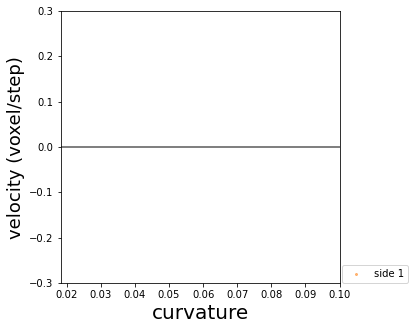

<Figure size 432x288 with 0 Axes>

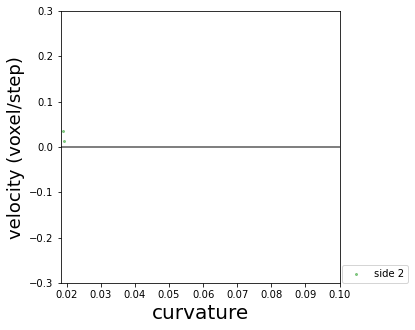

<Figure size 432x288 with 0 Axes>

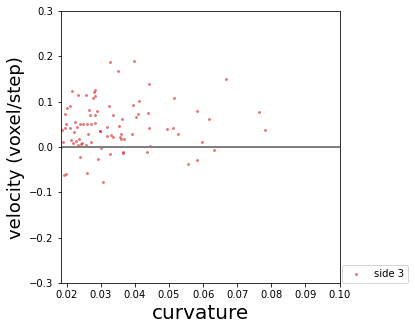

<Figure size 432x288 with 0 Axes>

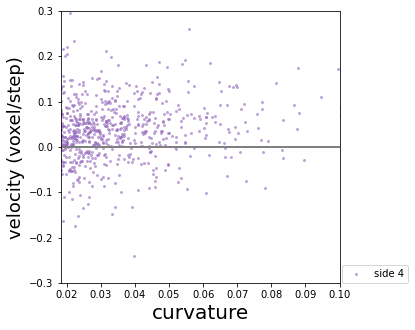

<Figure size 432x288 with 0 Axes>

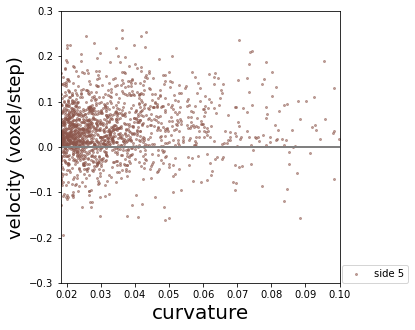

<Figure size 432x288 with 0 Axes>

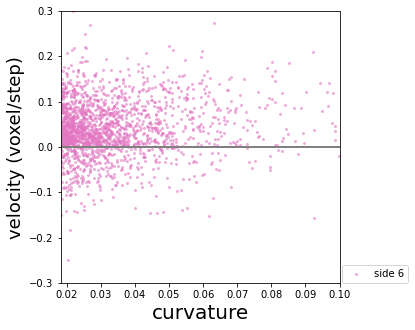

<Figure size 432x288 with 0 Axes>

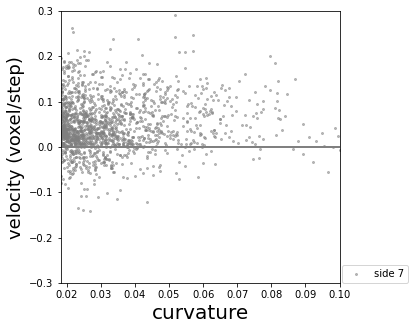

<Figure size 432x288 with 0 Axes>

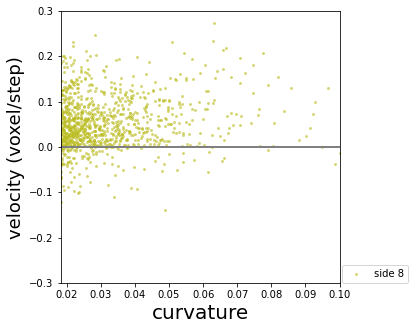

<Figure size 432x288 with 0 Axes>

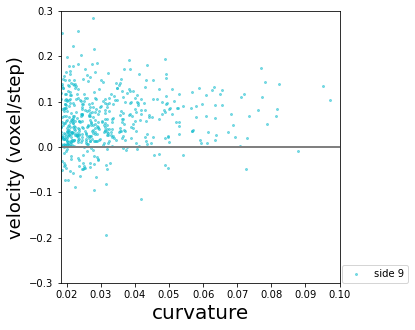

<Figure size 432x288 with 0 Axes>

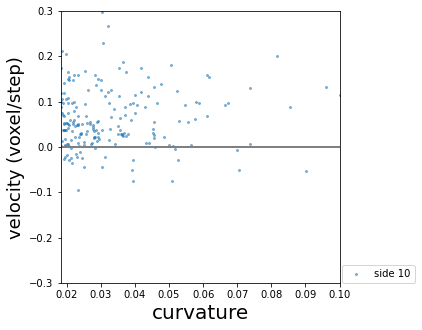

<Figure size 432x288 with 0 Axes>

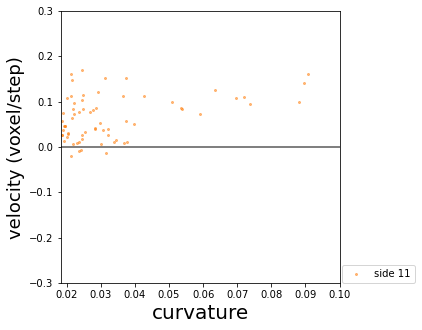

<Figure size 432x288 with 0 Axes>

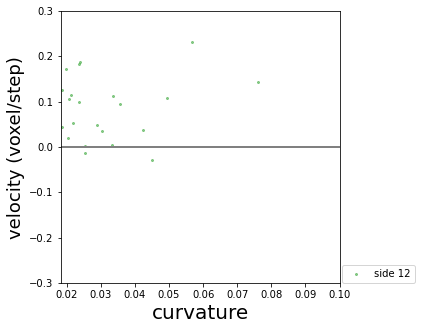

In [41]:
    # figure_name_all = f"figures/2D_velocity_signedcurvature_{case_name}_5d.png"
    GB_normc_list_sides_array = np.array(GB_normc_list_sides_list)
    GB_antic_list_sides_array = np.array(GB_antic_list_sides_list)
    GB_normc_list_curvature_array = np.array(GB_normc_list_curvature_list)
    GB_antic_list_curvature_array = np.array(GB_antic_list_curvature_list)
    GB_normc_list_velocity_array = np.array(GB_normc_list_velocity_list)
    GB_antic_list_velocity_array = np.array(GB_antic_list_velocity_list)
    for side_i in [1,2,3,4,5,6,7,8,9,10,11,12]:
        plt.figure()
        fig = plt.figure(figsize=(5, 5))
        plt.plot([curvature_limit,0.1],[0,0],'-',color='grey',linewidth=2)
    
        plt.scatter(GB_normc_list_curvature_array[GB_normc_list_sides_array==side_i], GB_normc_list_velocity_array[GB_normc_list_sides_array==side_i],s=4,alpha=0.5,color=f'C{side_i}',label=f"side {side_i}")
        plt.scatter(GB_antic_list_curvature_array[GB_antic_list_sides_array==side_i], GB_antic_list_velocity_array[GB_antic_list_sides_array==side_i],s=4,alpha=0.5,color=f'C{side_i}')
        plt.xlabel("curvature", fontsize=20)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([curvature_limit,0.1])
        plt.ylim([-0.3,0.3])
        plt.legend(loc=[1.01,0])
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')